In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [241]:
data = pd.read_csv('IPM20222023label.csv')

In [242]:
data['kategori'].value_counts()

Perlu Pembangunan          3378
Tidak Perlu Pembangunan     718
Name: kategori, dtype: int64

In [243]:
features = ['HLS', 'PPM', 'AHHL', 'AHHP', 'IPM']
target= 'kategori'


In [244]:
data.replace('-', float('nan'), inplace=True)

In [245]:
data.isna().sum()

Nama_Daerah    0
HLS            0
PPM            2
IPM            0
AHHL           0
AHHP           0
kategori       0
dtype: int64

In [246]:
data.dropna(inplace=True)

In [247]:
X = data[features]
y = data[target]

In [248]:
y_encoded = pd.factorize(y)[0]
target_names = pd.factorize(y)[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

In [249]:
print("Kategori dan Encode:")
for i, category in enumerate(target_names):
    print(f"{category}: {i}")

Kategori dan Encode:
Perlu Pembangunan: 0
Tidak Perlu Pembangunan: 1


In [250]:

# Smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
# X_resampled = X_resampled.round(2)

In [251]:
X_train1 = X_train
print(f"Jumlah data sebelum SMOTE: {X_train.shape[0]}")
print(f"Jumlah data setelah SMOTE: {X_resampled.shape[0]}")

Jumlah data sebelum SMOTE: 3684
Jumlah data setelah SMOTE: 6078


In [252]:
X_train = X_resampled
y_train = y_resampled

In [253]:
# Scalling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [254]:
def print_classification_report_with_loss(model_name, y_true, y_pred, model, X_test_scaled):
    print(f"{model_name} Classification Report:")
    
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled)
        loss = log_loss(y_true, y_pred_prob)
        print(f"Log Loss: {loss:.4f}")
    else:
        print(f"Log Loss: Model does not support probability predictions")
    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(f"Accuracy: {accuracy:.2f}")
    print(report)

In [255]:
def generate_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=[f"Actual {name}" for name in target_names], 
                         columns=[f"Predicted {name}" for name in target_names])
    
    print(f"\nConfusion Matrix for {model_name}:")
    print(cm_df)

    TN = cm[1, 1]
    TP = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    
    print(f"\nMetrics for {model_name}:")
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [256]:
ann_model = MLPClassifier(random_state=42, max_iter=1000)
svm_model = SVC(random_state=42, probability=True) 

In [257]:
models = {
    "ANN": ann_model,
    "SVM": svm_model
}

Training ANN...
ANN Classification Report:
Log Loss: 0.0286
Accuracy: 0.99
                         precision    recall  f1-score   support

      Perlu Pembangunan       0.99      1.00      1.00       338
Tidak Perlu Pembangunan       0.99      0.97      0.98        72

               accuracy                           0.99       410
              macro avg       0.99      0.98      0.99       410
           weighted avg       0.99      0.99      0.99       410


Confusion Matrix for ANN:
                                Predicted Perlu Pembangunan  \
Actual Perlu Pembangunan                                337   
Actual Tidak Perlu Pembangunan                            2   

                                Predicted Tidak Perlu Pembangunan  
Actual Perlu Pembangunan                                        1  
Actual Tidak Perlu Pembangunan                                 70  

Metrics for ANN:
True Positive (TP): 337
True Negative (TN): 70
False Positive (FP): 2
False Negative (FN): 1


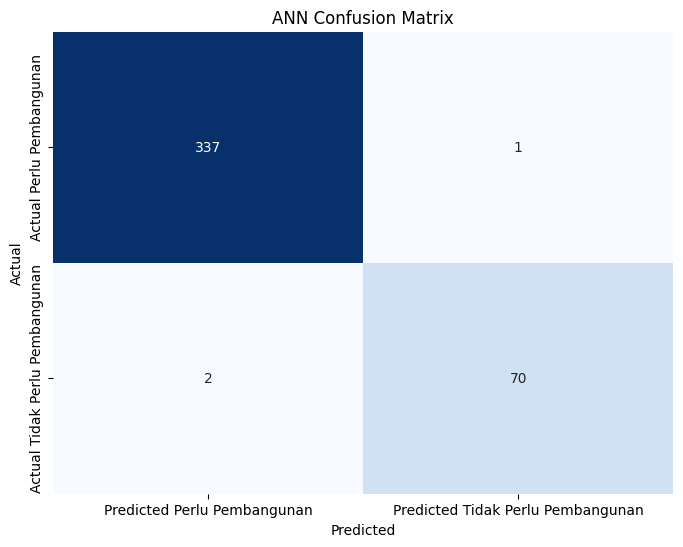

Training SVM...
SVM Classification Report:
Log Loss: 0.0424
Accuracy: 0.97
                         precision    recall  f1-score   support

      Perlu Pembangunan       1.00      0.97      0.98       338
Tidak Perlu Pembangunan       0.87      0.99      0.92        72

               accuracy                           0.97       410
              macro avg       0.93      0.98      0.95       410
           weighted avg       0.97      0.97      0.97       410


Confusion Matrix for SVM:
                                Predicted Perlu Pembangunan  \
Actual Perlu Pembangunan                                327   
Actual Tidak Perlu Pembangunan                            1   

                                Predicted Tidak Perlu Pembangunan  
Actual Perlu Pembangunan                                       11  
Actual Tidak Perlu Pembangunan                                 71  

Metrics for SVM:
True Positive (TP): 327
True Negative (TN): 71
False Positive (FP): 1
False Negative (FN): 11

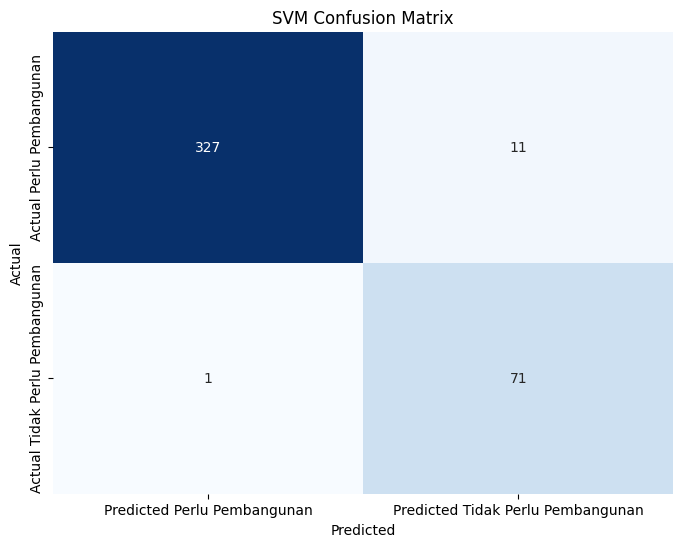

In [258]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print_classification_report_with_loss(model_name, y_test, y_pred, model, X_test_scaled)
    generate_confusion_matrix(y_test, y_pred, model_name)

In [259]:
new_data = pd.read_csv('IPM2024.csv')

new_data.replace('-', float('nan'), inplace=True)
new_data.dropna(inplace=True)

In [260]:
new_data

,nama_daerah,AHHL,AHHP,HLS,IPM,PPM
0,ACEH,68.07,71.94,14.39,74.03,14.23
1,Aceh Barat,65.96,69.93,14.93,73.69,17.60
2,Aceh Barat Daya,63.10,66.93,13.69,68.75,15.32
3,Aceh Besar,67.80,71.69,14.77,75.13,13.21
4,Aceh Jaya,65.19,69.09,14.06,71.83,12.25
...,...,...,...,...,...,...
533,Way Kanan,67.41,71.38,12.44,69.31,10.43
534,Wonogiri,74.44,78.13,12.61,72.55,10.71
535,Wonosobo,70.01,73.84,11.81,69.82,15.28
536,Yahukimo,64.15,67.94,8.05,51.98,33.82


In [261]:
X_new = new_data[features]

X_new_scaled = scaler.transform(X_new)

In [262]:
ann_predictions = ann_model.predict(X_new_scaled)
ann_predicted_labels = target_names[ann_predictions]
new_data_ann = new_data.copy()
new_data_ann['Predicted_ANN'] = ann_predicted_labels

new_data_ann.to_csv('IPM2024_with_ann.csv', index=False)

In [263]:
data_2024 = pd.read_csv('IPM2024_with_ann.csv')

In [264]:
data_2024['Predicted_ANN'].value_counts()

Tidak Perlu Pembangunan    343
Perlu Pembangunan          195
Name: Predicted_ANN, dtype: int64

In [265]:
perlu_pembangunan = data_2024[data_2024["Predicted_ANN"] == "Perlu Pembangunan"]

print("Daerah yang perlu pembangunan:")
for daerah in perlu_pembangunan["nama_daerah"]:
    print(daerah)

Daerah yang perlu pembangunan:
Aceh Barat Daya
Aceh Selatan
Alor
Asmat
Banggai Kepulauan
Banggai Laut
Bangka Selatan
Bangkalan
Banjarnegara
Banyu Asin
Barito Kuala
Belu
Bengkulu Tengah
Biak Numfor
Bima
Boalemo
Bolaang Mongondow Selatan
Bolaang Mongondow Timur
Bolaang Mongondow Utara
Bombana
Bondowoso
Bone
Boven Digoel
Brebes
Buru
Buru Selatan
Buton
Buton Selatan
Buton Tengah
Cianjur
Deiyai
Dogiyai
Donggala
Empat Lawang
Ende
Flores Timur
Garut
Gayo Lues
Gorontalo
Gorontalo Utara
Halmahera Barat
Halmahera Selatan
Halmahera Tengah
Halmahera Timur
Hulu Sungai Selatan
Hulu Sungai Tengah
Hulu Sungai Utara
Indragiri Hilir
Indramayu
Intan Jaya
Jayawijaya
Jember
Jeneponto
Kaimana
Kapuas Hulu
Katingan
Kaur
Kayong Utara
Keerom
Kepulauan Aru
Kepulauan Mentawai
Kepulauan Meranti
Kepulauan Sula
Kepulauan Yapen
Ketapang
Konawe Kepulauan
Kota Cilegon
Kota Pagar Alam
Kota Subulussalam
Kota Tanjung Balai
Kota Tual
Kupang
Lahat
Lampung Barat
Lampung Utara
Landak
Lanny Jaya
Lebak
Lebong
Lembata
Lingga
Lom

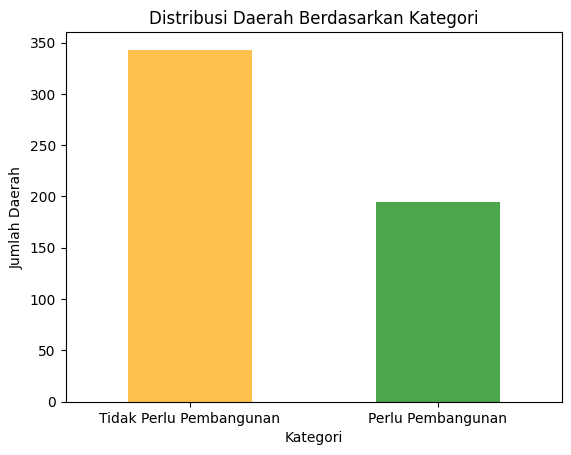

In [266]:
kategori_counts = data_2024["Predicted_ANN"].value_counts()

kategori_counts.plot(kind="bar", color=["orange", "green"], alpha=0.7)
plt.title("Distribusi Daerah Berdasarkan Kategori")
plt.ylabel("Jumlah Daerah")
plt.xlabel("Kategori")
plt.xticks(rotation=0)
plt.show()


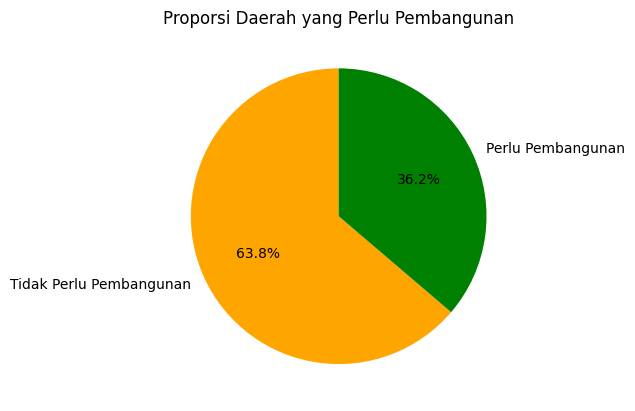

In [267]:
kategori_counts.plot(kind="pie", autopct="%1.1f%%", colors=["orange", "green"], startangle=90)
plt.title("Proporsi Daerah yang Perlu Pembangunan")
plt.ylabel("")
plt.show()


Kalau dari SVC

In [268]:
svc_predictions = svm_model.predict(X_new_scaled)
svc_predicted_labels = target_names[svc_predictions]

new_data_svc = new_data.copy()
new_data_svc['Predicted_SVC'] = svc_predicted_labels

new_data_svc.to_csv('IPM2024_with_svc.csv', index=False)

In [269]:
data_2024_svc = pd.read_csv('IPM2024_with_SVC.csv')

In [270]:
data_2024_svc['Predicted_SVC'].value_counts()

Tidak Perlu Pembangunan    378
Perlu Pembangunan          160
Name: Predicted_SVC, dtype: int64

In [271]:
perlu_pembangunan_svc = data_2024_svc[data_2024_svc["Predicted_SVC"] == "Perlu Pembangunan"]

print("Daerah yang perlu pembangunan:")
for daerah in perlu_pembangunan_svc["nama_daerah"]:
    print(daerah)

Daerah yang perlu pembangunan:
Aceh Barat Daya
Aceh Selatan
Alor
Asmat
Banggai Kepulauan
Banggai Laut
Bangka Selatan
Bangkalan
Barito Kuala
Belu
Bima
Boalemo
Bolaang Mongondow Selatan
Bolaang Mongondow Timur
Bolaang Mongondow Utara
Bombana
Bondowoso
Bone
Boven Digoel
Brebes
Buru
Buru Selatan
Buton Selatan
Buton Tengah
Cianjur
Deiyai
Dogiyai
Donggala
Empat Lawang
Ende
Flores Timur
Gayo Lues
Gorontalo
Gorontalo Utara
Halmahera Barat
Halmahera Selatan
Halmahera Tengah
Hulu Sungai Selatan
Hulu Sungai Tengah
Hulu Sungai Utara
Indragiri Hilir
Intan Jaya
Jayawijaya
Jeneponto
Kaimana
Katingan
Kaur
Kayong Utara
Keerom
Kepulauan Aru
Kepulauan Mentawai
Kepulauan Meranti
Kepulauan Sula
Kepulauan Yapen
Konawe Kepulauan
Kota Subulussalam
Kota Tanjung Balai
Kota Tual
Kupang
Lahat
Lampung Barat
Lampung Utara
Lanny Jaya
Lebak
Lebong
Lembata
Lingga
Lombok Tengah
Lombok Timur
Lombok Utara
Majene
Malaka
Maluku Barat Daya
Maluku Tenggara
Mamasa
Mamberamo Raya
Mamberamo Tengah
Mamuju Tengah
Mandailing Natal

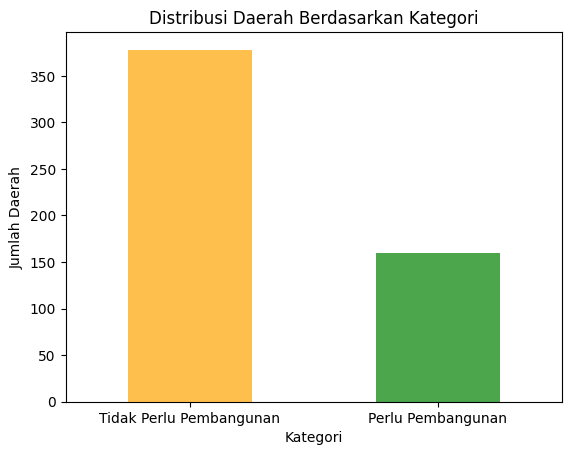

In [272]:
kategori_counts_svc = data_2024_svc["Predicted_SVC"].value_counts()

kategori_counts_svc.plot(kind="bar", color=["orange", "green"], alpha=0.7)
plt.title("Distribusi Daerah Berdasarkan Kategori")
plt.ylabel("Jumlah Daerah")
plt.xlabel("Kategori")
plt.xticks(rotation=0)
plt.show()

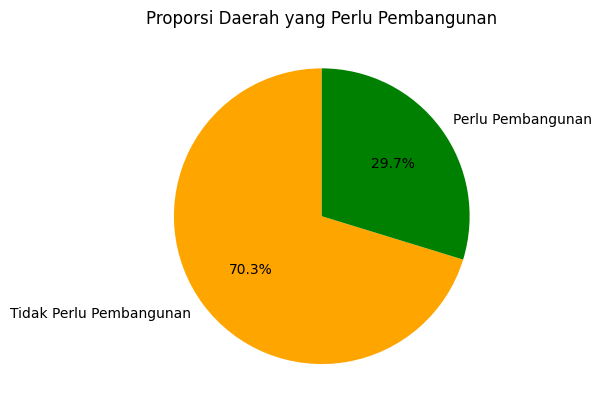

In [273]:
kategori_counts_svc.plot(kind="pie", autopct="%1.1f%%", colors=["orange", "green"], startangle=90)
plt.title("Proporsi Daerah yang Perlu Pembangunan")
plt.ylabel("")
plt.show()